In [8]:
from matplotlib import pyplot as plt
from astroquery.vizier import Vizier
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from sqlite3 import connect
import pandas as pd
from collections import defaultdict
import os
import numpy as np
import matplotlib.patches as plp
import scipy.stats as st
from astropy.time import Time
import scipy
from astropy.coordinates import search_around_sky
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import integrate


class Image:
    def __init__(self, fname='', hdr={}, data=[]):
        self._fname = fname
        self.hdr = hdr
        self.data = data
    
    @property
    def width(self):
        try:
            return self.data.shape[0]
        except Exception as e:
            return 0
    
    @property
    def height(self):
        try:
            return self.data.shape[1]
        except:
            return 0
    
    @property
    def fname(self):
        return self._fname
    
    def __str__(self):
        return f"<Image {self.width}x{self.height}>"
    
    __repr__ = __str__
    
def imread(path):
    hdr, data = {}, []
    with fits.open(path, 'readonly', ignore_missing_end=True) as f:
        hdu = f[0]
        hdr = getattr(hdu, 'header', {})
        data = getattr(hdu, 'data', [])
        
    return Image(path, hdr=hdr, data=data)

def imsave(img, path=''):
    if path:
        fits.writeto(path, img.data, img.hdr, overwrite=True)
    else:
        fits.writeto(img.fname, img.data, img.hdr, overwrite=True)
        
def sql2pandas(db_path):
    
    df = defaultdict(list)
    cols = ['x', 'x_err', 'y', 'y_err', 'ra_deg', 'ra_err', 'dec_deg', 'dec_err', 'mag', 'mag_err']
    
    # Avoid creating of a new DB by sqlite3 if it doesn't exist on the path
    if not os.path.isfile(db_path):
        raise IOError(f"No such file \"{db_path}\"")
    
    # Use a context manager to automatically close the DB after reading data
    # This prevents accidental changes to the DB and release R/W block
    with connect(db_path) as conn:
        for row in conn.cursor().execute(
            'SELECT x, x_err, y, y_err, ra_deg, ra_err, dec_deg, dec_err, mag, mag_err FROM objects'):
            df['x'].append(row[0])
            df['x_err'].append(row[1])
            df['y'].append(row[2])
            df['y_err'].append(row[3])
            df['ra_deg'].append(row[4])
            df['ra_err'].append(row[5])
            df['dec_deg'].append(row[6])
            df['dec_err'].append(row[7])
            df['mag'].append(row[8])
            df['mag_err'].append(row[9])
            
    return pd.DataFrame(df, columns=cols)

In [9]:
img = imread('test.fits')

In [10]:
w = WCS(img.hdr)

xscale, yscale = (abs(w.wcs.cdelt) * u.deg).to(u.arcsec)
field_center = SkyCoord(*w.wcs.crval, unit=[u.deg, u.deg])
region_width = img.width * xscale
region_height = img.height * yscale

# field_center: (243.9021249, 14.41539495)

ps1 = pd.read_csv("PS_60archmin.txt", sep=';')
sdss12 = pd.read_csv("SDSS_61archmin.txt", sep=';')
# sdss16=pd.read_csv("SDSS16_20archmin.txt", sep=';')
#ps1=sdss16
#sdss12_pm=sdss12.dropna()
#sdss12_no_pm=sdss12.loc[~sdss12.index.isin(sdss12.dropna().index)]
#print(len(sdss12),len(sdss12_pm),len(sdss12_no_pm))

D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Предобработка данных Pan-STARRS

In [11]:
ps1

,RAJ2000,DEJ2000,objID,e_RAJ2000,e_DEJ2000,Epoch,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,ymag,e_ymag
0,243.901649,14.418645,125302439016542896,0.0148,0.0156,56126.982500000,,,21.8335,0.1839,20.6252,0.0267,19.8928,0.0295,19.4420,0.0345
1,243.898891,14.413379,125292438988696580,5.1135,52.7368,55496.351180560,,,,,21.7642,0.0373,,,,NaN
2,243.898264,14.413391,125292438982846584,0.1774,0.1774,55351.359918980,,,,,22.2077,0.1767,,,,NaN
3,243.906360,14.417050,125302439063610959,0.0225,0.0161,56016.521111110,18.2362,0.0109,17.3499,0.0043,17.0184,0.0041,16.8501,0.0037,16.7377,0.0060
4,243.896734,14.413301,125292438967326401,0.0463,0.0554,56021.957708330,,,,,21.6200,0.0562,20.9082,0.1512,20.7497,0.1923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102028,243.973792,13.417862,124102439738881997,0.0476,0.0476,56800.541932870,,,,,20.1346,0.0441,20.6267,0.1660,,NaN
102029,243.379359,13.553653,124262433793784906,0.0205,0.0232,55978.871319440,,,21.9627,0.0215,21.0936,0.0464,20.2913,0.0533,19.9328,0.1013
102030,242.878917,14.283929,125142428789091249,0.0136,0.0168,56151.949293980,22.3361,0.0900,21.0674,0.0506,20.4077,0.0245,20.0931,0.0369,19.9773,0.0240
102031,244.851006,14.811470,125772448509894298,0.0769,0.0769,56454.118148150,22.4155,0.1851,22.0352,0.0746,21.5869,0.1962,21.4219,0.1919,,NaN


In [12]:
suspect_list=[]

for i,j in enumerate(ps1['Epoch']): #Объекты без указания эпохи наблюдения и других данных
    try:
#         float(j)+float(ps1['e_RAJ2000'][i])+float(ps1['e_DEJ2000'][i])+float(ps1['gmag'][i])+float(ps1['e_gmag'][i])+float(ps1['rmag'][i])+float(ps1['e_rmag'][i])+float(ps1['imag'][i])+float(ps1['e_imag'][i])+float(ps1['zmag'][i])+float(ps1['e_zmag'][i])+float(ps1['ymag'][i])+float(ps1['e_ymag'][i])
        float(j)+float(ps1['e_RAJ2000'][i])+float(ps1['e_DEJ2000'][i])
    except ValueError:
        suspect_list.append(i)

suspect_list.append(1)

In [13]:
ps11=ps1.drop(labels=suspect_list, axis=0)

times = ps11['Epoch'].to_numpy(dtype=str)
t1 = Time(times, format='mjd', scale='utc')
t=t1.jyear

features={'RA1': ps11['RAJ2000'],
              'e_RA1': ps11['e_RAJ2000'],
              
              'DE1': ps11['DEJ2000'],
              'e_DE1': ps11['e_DEJ2000'],
              
              't1': t.astype(float)-2000,
              
              'g1': ps11['gmag'],
              'e_g1': ps11['e_gmag'],
              
              'r1': ps11['rmag'],
              'e_r1': ps11['e_rmag'],
        
              'i1': ps11['imag'],
              'e_i1': ps11['e_imag'],
              
              'z1': ps11['zmag'],
              'e_z1': ps11['e_zmag'],
             
             }

ps=pd.DataFrame(data=features)
ps

,RA1,e_RA1,DE1,e_DE1,t1,g1,e_g1,r1,e_r1,i1,e_i1,z1,e_z1
0,243.901649,0.0148,14.418645,0.0156,12.546153,,,21.8335,0.1839,20.6252,0.0267,19.8928,0.0295
2,243.898264,0.1774,14.413391,0.1774,10.422614,,,,,22.2077,0.1767,,
3,243.906360,0.0225,14.417050,0.0161,12.243727,18.2362,0.0109,17.3499,0.0043,17.0184,0.0041,16.8501,0.0037
4,243.896734,0.0463,14.413301,0.0554,12.258611,,,,,21.6200,0.0562,20.9082,0.1512
5,243.897010,0.0347,14.419650,0.0352,12.195885,,,,,21.3267,0.0450,20.6091,0.0660
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102028,243.973792,0.0476,13.417862,0.0476,14.390259,,,,,20.1346,0.0441,20.6267,0.1660
102029,243.379359,0.0205,13.553653,0.0232,12.140647,,,21.9627,0.0215,21.0936,0.0464,20.2913,0.0533
102030,242.878917,0.0136,14.283929,0.0168,12.614509,22.3361,0.0900,21.0674,0.0506,20.4077,0.0245,20.0931,0.0369
102031,244.851006,0.0769,14.811470,0.0769,13.441802,22.4155,0.1851,22.0352,0.0746,21.5869,0.1962,21.4219,0.1919


## Предобработка данных SDSS


In [14]:
features12={'RA2': sdss12['RA_ICRS'], 
                  
              'e_RA2': sdss12['e_RA_ICRS'],
              
              'DE2': sdss12['DE_ICRS'],
              'e_DE2': sdss12['e_DE_ICRS'],
                  
              'pmRA2': sdss12['pmRA'],
                  
              'pmDE2': sdss12['pmDE'],
              
              'g2': sdss12['gmag'],
              'e_g2': sdss12['e_gmag'],
              
              'r2': sdss12['rmag'],
              'e_r2': sdss12['e_rmag'],
              
              'i2': sdss12['imag'],
              'e_i2': sdss12['e_imag'],
              
              'z2': sdss12['zmag'],
              'e_z2': sdss12['e_zmag']
              
              }

sdss12_1=pd.DataFrame(data=features12)
sdss12_1

,RA2,e_RA2,DE2,e_DE2,pmRA2,pmDE2,g2,e_g2,r2,e_r2,i2,e_i2,z2,e_z2
0,243.901639,0.070,14.418688,0.068,,,23.867,0.387,21.864,0.094,20.442,0.043,19.591,0.071
1,243.898866,0.100,14.413421,0.108,,,23.792,0.529,21.54,0.104,21.360,0.137,23.313,0.828
2,243.898211,0.102,14.413378,0.098,,,24.281,0.413,23.198,0.228,22.421,0.178,22.812,0.487
3,243.906359,0.002,14.417066,0.002,-6.8,-3.5,18.363,0.007,17.339,0.005,16.981,0.005,16.770,0.009
4,243.906030,0.125,14.418227,0.108,,,23.990,0.387,23.08,0.237,21.987,0.144,21.536,0.321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119998,242.961543,0.001,14.868630,0.001,-22.0,-4.0,16.929,0.004,15.670,0.004,15.189,0.004,14.938,0.005
119999,242.980512,0.140,14.903892,0.164,,,22.947,0.166,23.332,0.339,23.552,0.651,21.434,0.436
120000,243.420116,0.094,13.512734,0.134,,,25.006,0.538,23.056,0.222,21.572,0.088,21.290,0.274
120001,244.297686,0.071,13.474002,0.068,,,23.524,0.219,22.766,0.176,22.561,0.197,22.596,0.577


# Смотр

In [15]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# ax1.scatter(ps['RA1'], ps['DE1'], marker = 'o',
#                    c = 'r',
#                    s=50,
#                    linewidths = 2,
#                    edgecolors = 'darkred',
#           alpha=0.85, label='PS1 obj.')

# # ax1.scatter(sdss['RA2'], sdss['DE2'], s=5, c='w', label='SDSS DR12 obj.')


# ax2.scatter(sdss['RA2'], sdss['DE2'], s=30, c='w', label='SDSS DR12 obj.')

# ax1.set_facecolor('black')
# ax1.set_xlabel('RA, deg.')
# ax1.set_ylabel('DEC, deg.')

# ax2.set_facecolor('black')
# ax2.set_xlabel('RA, deg.')
# ax2.set_ylabel('DEC, deg.')

# ax1.grid()
# ax1.legend()
# ax2.grid()
# ax2.legend()

# center=[np.mean(ps['RA1']), np.mean(ps['DE1'])]   #scaling
# delta=np.max(ps['RA1'])-np.mean(ps['RA1'])

# s=0.025
# d=0.1

# ax1.set_xlim(center[0]-s*delta+d, center[0]+s*delta+d)
# ax1.set_ylim(center[1]-s*delta+d, center[1]+s*delta+d)

# ax2.set_xlim(center[0]-s*delta+d, center[0]+s*delta+d)
# ax2.set_ylim(center[1]-s*delta+d, center[1]+s*delta+d)


# plt.savefig('prob1')

# Матчинг и его оценка

In [16]:
%%time
ps_coords=SkyCoord(ps['RA1'], ps['DE1'], unit=[u.deg]*2)
sdss12_coords=SkyCoord(sdss12_1['RA2'], sdss12_1['DE2'], unit=[u.deg]*2)

Wall time: 5.81 s


## Ближайшие соседи в R=20arcsec (для полноты)

In [17]:
%%time
limit=12*u.arcsec
all_neighbours=search_around_sky(ps_coords, sdss12_coords, seplimit=limit, storekdtree='kdtree_sky')

Wall time: 336 ms


# Локальные плотности

In [18]:
def nearest_neigbour_method(cat1, cat2, epsilon):
    
    coords1=SkyCoord(cat1['RA1'], cat1['DE1'], unit=[u.deg]*2)
    coords2=SkyCoord(cat2['RA2'], cat2['DE2'], unit=[u.deg]*2)
    
    a=SkyCoord.match_to_catalog_sky(coords1, coords2)
    
    xm_features={'ps_id': cat1.index,
             'sdss_id': cat2.iloc[a[0]].index,
             'sep, arcsec': a[1].to(u.arcsec).value}

    xm_result=pd.DataFrame(data=xm_features)

    xm_result=xm_result.astype({"ps_id": int,
                  "sdss_id": int,
                  'sep, arcsec': float})
    
    return xm_result.loc[xm_result['sep, arcsec']<epsilon]

In [19]:
def get_local_densities(cat1, cat2, R):
    
    coords1=SkyCoord(cat1['RA1'], cat1['DE1'], unit=[u.deg]*2)
    coords2=SkyCoord(cat2['RA2'], cat2['DE2'], unit=[u.deg]*2)
    
    R_b=R * u.arcsec
    
    a1=search_around_sky(coords1, coords2, seplimit=R_b, storekdtree='kdtree_sky')
    
    features={'ps_id': cat1.iloc[a1[0]].index,
             'sdss_id': cat2.iloc[a1[1]].index,
             'sep, arcsec': a1[2].to(u.arcsec).value}

    xm_result1=pd.DataFrame(data=features)

    xm_result=xm_result1.astype({"ps_id": int,
                  "sdss_id": int,
                  'sep, arcsec': float})
    
    densities=xm_result.groupby(['ps_id']).size().to_frame('loc. density')/(np.pi*R_b.value**2)
    
    return densities

In [20]:
# def nearest_neigbour_method_precision_recall(cat1, cat2, epsilon, R):
    
#     xm_result=nearest_neigbour_method(cat1, cat2, epsilon)
#     densities=get_local_densities(cat1.loc[xm_result['ps_id']], cat2, R)
    
#     return xm_result.join(densities, on='ps_id')

In [21]:
%%time
densities=get_local_densities(ps, sdss12_1, 60)
densities

Wall time: 9.01 s


,loc. density
ps_id,
0,0.002741
2,0.002564
3,0.002476
4,0.002564
5,0.002829
...,...
102028,0.003448
102029,0.000442
102030,0.002741


In [41]:
%%time
xm_result=nearest_neigbour_method(ps, sdss12_1, 2)
xm_result

Wall time: 6.08 s


,ps_id,sdss_id,"sep, arcsec"
0,0,0,0.160092
1,2,2,0.192040
2,3,3,0.057003
3,4,5,0.089399
4,5,6,0.141525
...,...,...,...
101853,102025,116102,0.028972
101854,102026,116098,0.250917
101855,102027,116105,0.122544
101858,102030,116106,0.145580


# Оценка точности

In [39]:
def get_precision(results, densities):
    
    intrm=results.join(densities, on='ps_id')
    prob=np.exp(-intrm['loc. density']*np.pi*intrm['sep, arcsec']**2)
    res=intrm.join(prob.to_frame('P'))
    
    return np.sum(res['P'])/len(res)*100

In [42]:
get_precision(xm_result, densities)

99.89810025209034

# Оценка полноты

In [35]:
def get_recall(xm_results, all_neighbours):
    
    bins=np.linspace(0.0001, 12, int(np.round(len(all_neighbours[2].to(u.arcsec).value)/12)))
    n1, bins1=np.histogram(all_neighbours[2].to(u.arcsec).value, bins=bins)
    n2, bins2=np.histogram(xm_results['sep, arcsec'], bins=bins)
    
    def lf(x, a):
        return a*x

    #Линейная аппроксимация хвоста
    startfit=int(np.round(0.1*int(np.round(len(all_neighbours[2].to(u.arcsec).value)/12))))
    endfit=int(np.round(0.9*int(np.round(len(all_neighbours[2].to(u.arcsec).value)/12))))

    linpopt, linpcov = curve_fit(lf, bins1[startfit:endfit], n1[startfit:endfit])
    
    #Аппроксимация функциями
    xtest1=bins1[1:-1]
    ytest1=n1[1:]

    xtest2=bins2[1:-1]
    ytest2=n2[1:]

    def f1(x, a, b, c, d):
        return c/(b*x)*np.exp(-((np.log(x)-a)/b)**2)+d*x

    def f2(x, a, b, c):
        return c/(b*x)*np.exp(-((np.log(x)-a)/b)**2)

    popt1, pcov1 = curve_fit(f1, xtest1, ytest1)
    popt2, pcov2 = curve_fit(f2, xtest2, ytest2)
    
    #Непрерывный
    x2=lambda x: f2(x, *popt2)
    x1_ml=lambda x: f1(x, *popt1)-lf(x, *linpopt)

    I2=integrate.quad(x2, 0, 5)
    I1=integrate.quad(x1_ml, 0, 5)

    integ=I2[0]/I1[0]*100

    #Дискретный
    
    k=np.searchsorted(bins1, 5, side="left")
    p1=np.searchsorted(bins1, .01, side="left")
    p=0
    
    s2_d=np.sum(n2[p:k])

    d11=np.zeros(len(n1[p:k]))
    d11[p1:k]=lf(bins1[p1:k], *linpopt)

    d1=n1[p:k]-d11
    d1[d1<0]=0
    s1_d=np.sum(d1)

    d=s2_d/s1_d*100
    
    return (integ+d)/2
    

In [43]:
get_recall(xm_result, all_neighbours)

100.18800308023125

## Желанный график

In [44]:
densities=get_local_densities(ps, sdss12_1, 60)
all_neighbours=search_around_sky(ps_coords, sdss12_coords, seplimit=limit, storekdtree='kdtree_sky')

In [45]:
eps=np.linspace(0.1, 3.5, 50)
data=[]
for i in eps:
    m_res=nearest_neigbour_method(ps, sdss12_1, i)
    data.append((get_precision(m_res, densities), get_recall(m_res, all_neighbours)))

(99.25, 100.25)

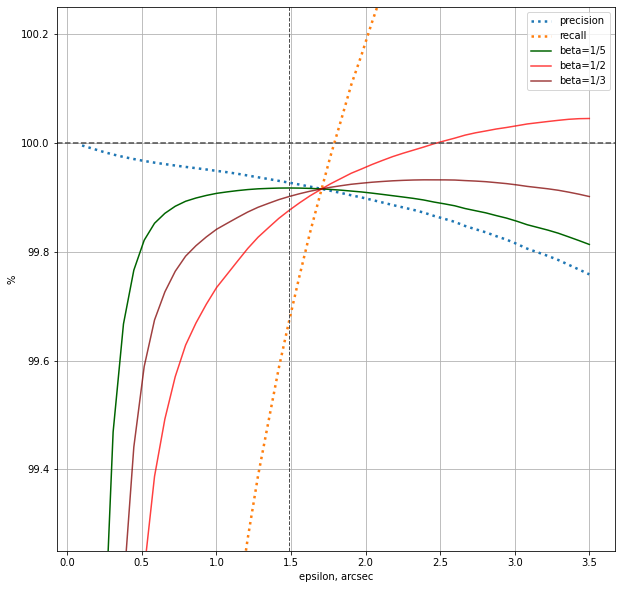

In [343]:
pr=np.array((data))[:,0]
rec=np.array((data))[:,1]

fig, ax = plt.subplots(figsize=(10,10))

ax.plot(eps, pr, label='precision', alpha = 1,  linestyle = ':', lw=2.5)
ax.plot(eps, rec, label='recall', alpha = 1,  linestyle = ':', lw=2.5)

ax.plot(eps, (1+1/25)*pr*rec/(1/25*pr+rec), label='beta=1/5', c='darkgreen')
ax.plot(eps, (1+1/4)*pr*rec/(1/4*pr+rec), label='beta=1/2',  alpha = 0.75, c='red')
ax.plot(eps, (1+1/9)*pr*rec/(1/9*pr+rec), label='beta=1/3',  alpha = 0.75, c='maroon')

plt.axhline(100, c='0.3', linestyle = '--')
plt.axvline(best_eps, c='0.3', linestyle = '--', lw=1)


ax.set_xlabel('epsilon, arcsec')
ax.set_ylabel('%')
plt.grid()
plt.legend()
plt.ylim(99.25,100.25)

In [63]:
def get_beta(table, beta):
    return ((1+beta**2)*table['precision']*table['recall'])/(beta**2*table['precision']+table['recall'])

In [64]:
res1=pd.concat([(pd.DataFrame(eps, columns=['epsilon'])), pd.DataFrame(data, columns=['precision', 'recall'])], axis=1)
res1['F0.2']=get_beta(res1, 0.2)
res1

,epsilon,precision,recall,F0.2
0,0.100000,99.995649,32.429683,92.577155
1,0.169388,99.989919,62.725025,97.756193
2,0.238776,99.984182,79.656189,99.012350
3,0.308163,99.979005,88.209389,99.468547
4,0.377551,99.974543,92.555829,99.667284
5,0.446939,99.970665,94.914534,99.766258
6,0.516327,99.967103,96.309726,99.821306
7,0.585714,99.964031,97.143671,99.852531
8,0.655102,99.961338,97.660014,99.870822
9,0.724490,99.958726,98.046857,99.883815


## Лучшее эпсилон

In [48]:
massive=(1+1/25)*pr*rec/(1/25*pr+rec)

best_eps=eps[np.where(massive == np.max(massive))[0][0]]
print(best_eps, np.max(massive))

1.4877551020408164 99.91741589391987


# Оценка полноты (визуализация)

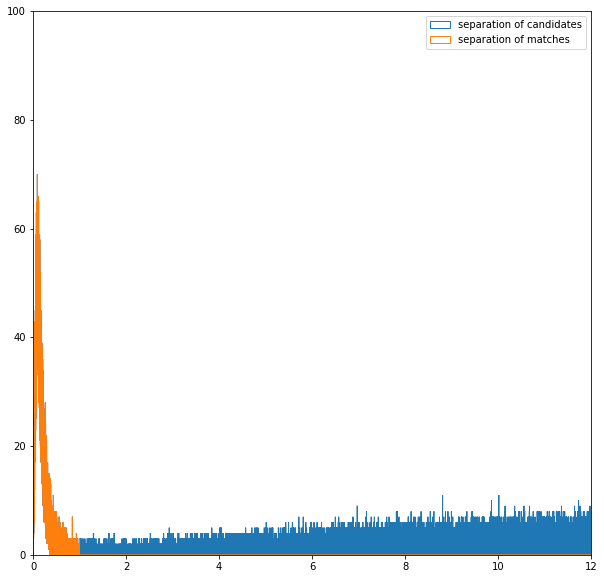

In [34]:
fig, ax = plt.subplots(figsize=(10,10))

bins=np.linspace(0.0001, 12, int(np.round(len(all_neighbours[2].to(u.arcsec).value)/2)))
n1, bins1, patches1=ax.hist(all_neighbours[2].to(u.arcsec).value, bins=bins, histtype='step', label='separation of candidates')
n2, bins2, patches2=ax.hist(xm_result['sep, arcsec'], bins=bins, histtype='step', label='separation of matches')

plt.xlim(0, 12)
plt.ylim(0, 100)
plt.legend()

## Аппроксимация хвоста

In [28]:
def lf(x, a):
    return a*x

startfit=int(np.round(0.1*int(np.round(len(all_neighbours[2].to(u.arcsec).value)/12))))
endfit=int(np.round(0.9*int(np.round(len(all_neighbours[2].to(u.arcsec).value)/12))))

linpopt, linpcov = curve_fit(lf, bins1[startfit:endfit], n1[startfit:endfit])
linpopt

array([1.14653927])

(-10.0, 10.0)

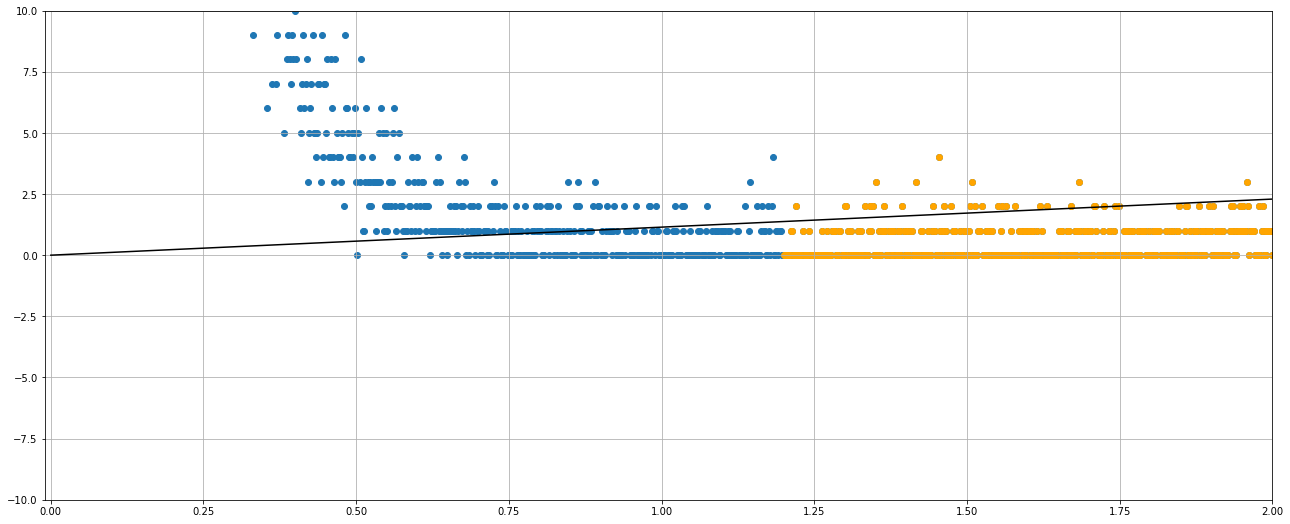

In [29]:
fig, ax=plt.subplots(figsize=(22,9))

ax.scatter(bins1[:-1], n1)
ax.scatter(bins1[startfit:endfit], n1[startfit:endfit], c='orange')
ax.plot(bins1, lf(bins1, *linpopt), c='k')

plt.grid()
plt.xlim(-0.01,2)
plt.ylim(-10,10)

## Теперь - аппроксимация функциями

In [30]:
xtest1=bins1[1:-1]
ytest1=n1[1:]

xtest2=bins2[1:-1]
ytest2=n2[1:]

def f1(x, a, b, c, d):
    return c/(b*x)*np.exp(-((np.log(x)-a)/b)**2)+d*x

def f2(x, a, b, c):
    return c/(b*x)*np.exp(-((np.log(x)-a)/b)**2)

popt1, pcov1 = curve_fit(f1, xtest1, ytest1)
popt2, pcov2 = curve_fit(f2, xtest2, ytest2)

(-2.0, 10.0)

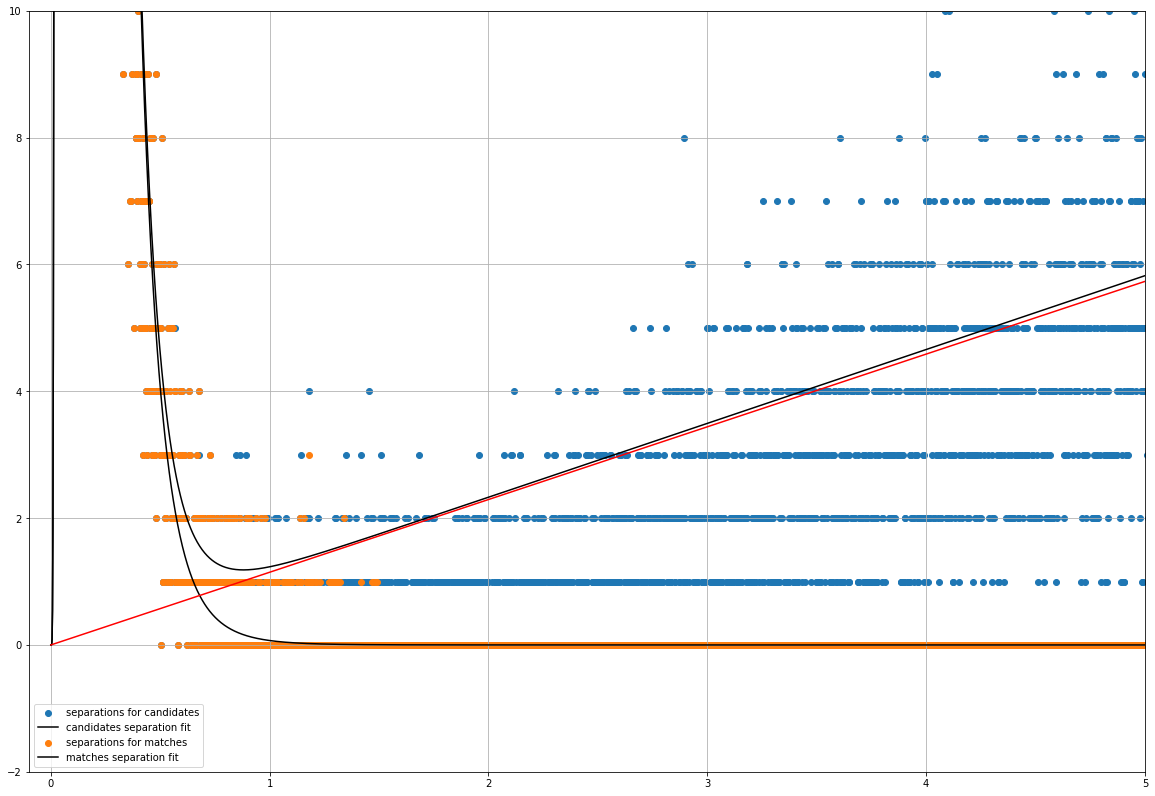

In [31]:
fig, ax=plt.subplots(figsize=(20,14))

ax.scatter(bins[:-1], n1, label='separations for candidates')
ax.plot(bins, f1(bins, *popt1), label='candidates separation fit', c='k')

ax.scatter(bins[:-1], n2, label='separations for matches')
ax.plot(bins, f2(bins, *popt2), label='matches separation fit', c='k')

ax.plot(bins1, lf(bins1, *linpopt), c='r')

plt.legend()
plt.grid()
plt.xlim(-0.1,5)
plt.ylim(-2, 10)

# Непрерывный

In [37]:
x2=lambda x: f2(x, *popt2)
x1_ml=lambda x: f1(x, *popt1)-lf(x, *linpopt)

I2=integrate.quad(x2, 0, 5)
I1=integrate.quad(x1_ml, 0, 5)
print(I1, I2)

integ=I2[0]/I1[0]*100
print(integ)

(64.60427225360138, 1.657745394808202e-07) (64.47938865538767, 1.6819317229897356e-07)
99.80669452056749


# Дискретный

In [40]:
k=np.searchsorted(bins1, 5, side="left")
p1=np.searchsorted(bins1, .01, side="left")
p=0
print(bins1[p1], bins1[k])

0.011374569370497963 5.000371515815847


In [42]:
s2_d=np.sum(n2[p:k])

d11=np.zeros(len(n1[p:k]))
d11[p1:k]=lf(bins1[p1:k], *linpopt)

d1=n1[p:k]-d11
d1[d1<0]=0
s1_d=np.sum(d1)

print(s1_d)
print(s2_d)
d=s2_d/s1_d*100
print(d)

34664.65075444135
34420.0
99.29423562875503


# Итоговый

In [43]:
(d+integ)/2

99.55046507466126

# Функцией

In [698]:
def get_recall(xm_results, all_neighbours):
    
    bins=np.linspace(0.0001, 12, int(np.round(len(all_neighbours[2].to(u.arcsec).value)/12)))
    n1, bins1=np.histogram(all_neighbours[2].to(u.arcsec).value, bins=bins)
    n2, bins2=np.histogram(xm_results['sep, arcsec'], bins=bins)
    
    def lf(x, a):
        return a*x

    #Линейная аппроксимация хвоста
    startfit=int(np.round(0.1*int(np.round(len(all_neighbours[2].to(u.arcsec).value)/12))))
    endfit=int(np.round(0.9*int(np.round(len(all_neighbours[2].to(u.arcsec).value)/12))))

    linpopt, linpcov = curve_fit(lf, bins1[startfit:endfit], n1[startfit:endfit])
    
    #Аппроксимация функциями
    xtest1=bins1[1:-1]
    ytest1=n1[1:]

    xtest2=bins2[1:-1]
    ytest2=n2[1:]

    def f1(x, a, b, c, d):
        return c/(b*x)*np.exp(-((np.log(x)-a)/b)**2)+d*x

    def f2(x, a, b, c):
        return c/(b*x)*np.exp(-((np.log(x)-a)/b)**2)

    popt1, pcov1 = curve_fit(f1, xtest1, ytest1)
    popt2, pcov2 = curve_fit(f2, xtest2, ytest2)
    
    #Непрерывный
    x2=lambda x: f2(x, *popt2)
    x1_ml=lambda x: f1(x, *popt1)-lf(x, *linpopt)

    I2=integrate.quad(x2, .45, 5)
    I1=integrate.quad(x1_ml, .45, 5)

    integ=I2[0]/I1[0]*100

    #Дискретный
    
    k=np.searchsorted(bins1, 5, side="left")
    p1=np.searchsorted(bins1, .45, side="left")
    p=0
    
    s2_d=np.sum(n2[p:k])

    d11=np.zeros(len(n1[p:k]))
    d11[p1:k]=lf(bins1[p1:k], *linpopt)

    d1=n1[p:k]-d11
    d1[d1<0]=0
    s1_d=np.sum(d1)

    d=s2_d/s1_d*100
    
    return (integ+d)/2
    

In [151]:
get_recall(xm_result, all_neighbours)

100.18800308023125

# Метод эллипсов ошибок

In [421]:
def sf_pandas(row):
    
    conf_level=0.9999994267
    q=st.chi2(df=2).ppf(conf_level)
    
    a1=np.array((row['RA1'], row['DE1']),dtype=float)
    a2=np.array((row['RA2'], row['DE2']),dtype=float)
    
    d = row['sep, arcsec']/3600
    

    Vm1=np.array(([(float(row['e_RA1'])/3600)**2, 0],
                  [0, (float(row['e_DE1'])/3600)**2]))
    
    Vm2=np.array(([(float(row['e_RA2_br'])/3600)**2, 0],
                  [0, (float(row['e_DE2_br'])/3600)**2]))
    
    if a2[0]-a1[0] < 0:
        theta=np.pi+np.arctan((a2[1]-a1[1])/(a2[0]-a1[0]))
        
    else:
        theta=np.arctan((a2[1]-a1[1])/(a2[0]-a1[0]))
    
    R=np.array((
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]))
    
    R_inv=np.array((
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]))
    
    Vm1_n=R@Vm1@R_inv
    Vm2_n=R@Vm2@R_inv
    Vc=Vm1_n+Vm2_n
    
    rho_c=Vc[0][1]
    statistic=d/(np.sqrt(Vc[0][0]*(1-rho_c**2)))
    
    return statistic

In [430]:
%%time
ps_coords=SkyCoord(ps['RA1'], ps['DE1'], unit=[u.deg]*2)
sdss12_coords=SkyCoord(sdss12_1['RA2'], sdss12_1['DE2'], unit=[u.deg]*2)

Wall time: 6.06 s


In [431]:
%%time

cat1=ps
cat2=sdss12_1
a2=search_around_sky(ps_coords, sdss12_coords, seplimit=5*u.arcsec, storekdtree='kdtree_sky')

Wall time: 253 ms


In [432]:
features2={'ps_id': cat1.iloc[a2[0]].index,
             'sdss_id': cat2.iloc[a2[1]].index,
             'sep, arcsec': a2[2].to(u.arcsec).value}

xm_result22=pd.DataFrame(data=features2)

xm_result2=xm_result22.astype({"ps_id": int,
                  "sdss_id": int,
                  'sep, arcsec': float})

intrm=xm_result2.join(ps, on='ps_id').join(sdss12_1, on='sdss_id')[['ps_id', 'sdss_id', 'sep, arcsec', 'RA1', 'e_RA1','DE1', 'e_DE1','RA2', 'e_RA2','DE2', 'e_DE2',]]
intrm

,ps_id,sdss_id,"sep, arcsec",RA1,e_RA1,DE1,e_DE1,RA2,e_RA2,DE2,e_DE2
0,0,0,0.160092,243.901649,0.0148,14.418645,0.0156,243.901639,0.070,14.418688,0.068
1,2,1,2.100582,243.898264,0.1774,14.413391,0.1774,243.898866,0.100,14.413421,0.108
2,2,2,0.192040,243.898264,0.1774,14.413391,0.1774,243.898211,0.102,14.413378,0.098
3,3,3,0.057003,243.906360,0.0225,14.417050,0.0161,243.906359,0.002,14.417066,0.002
4,3,4,4.390270,243.906360,0.0225,14.417050,0.0161,243.906030,0.125,14.418227,0.108
...,...,...,...,...,...,...,...,...,...,...,...
105366,102026,116098,0.250917,244.335747,0.0833,13.508301,0.0356,244.335795,0.017,13.508352,0.014
105367,102027,116105,0.122544,243.430425,0.0126,15.305360,0.0097,243.430434,0.014,15.305393,0.014
105368,102030,116106,0.145580,242.878917,0.0136,14.283929,0.0168,242.878900,0.033,14.283966,0.032
105369,102031,116099,0.341299,244.851006,0.0769,14.811470,0.0769,244.851000,0.139,14.811375,0.185


## Расширение ошибок SDSS 

In [440]:
k=1/2
delta_er=k*80*8/1000
delta_er

intrm['e_RA2_br']=intrm['e_RA2'].astype(float)+delta_er
intrm['e_DE2_br']=intrm['e_DE2'].astype(float)+delta_er

In [441]:
%%time
sigdist=intrm.apply(sf_pandas, axis=1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in sqrt


Wall time: 1min 16s


In [443]:
intrm2=intrm.join(sigdist.to_frame('sigdist'))
intrm2

,ps_id,sdss_id,"sep, arcsec",RA1,e_RA1,DE1,e_DE1,RA2,e_RA2,DE2,e_DE2,e_RA2_br,e_DE2_br,sigdist
0,0,0,0.160092,243.901649,0.0148,14.418645,0.0156,243.901639,0.070,14.418688,0.068,0.390,0.388,0.412163
1,2,1,2.100582,243.898264,0.1774,14.413391,0.1774,243.898866,0.100,14.413421,0.108,0.420,0.428,4.607080
2,2,2,0.192040,243.898264,0.1774,14.413391,0.1774,243.898211,0.102,14.413378,0.098,0.422,0.418,0.419710
3,3,3,0.057003,243.906360,0.0225,14.417050,0.0161,243.906359,0.002,14.417066,0.002,0.322,0.322,0.176805
4,3,4,4.390270,243.906360,0.0225,14.417050,0.0161,243.906030,0.125,14.418227,0.108,0.445,0.428,10.219714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105366,102026,116098,0.250917,244.335747,0.0833,13.508301,0.0356,244.335795,0.017,13.508352,0.014,0.337,0.334,0.735312
105367,102027,116105,0.122544,243.430425,0.0126,15.305360,0.0097,243.430434,0.014,15.305393,0.014,0.334,0.334,0.366736
105368,102030,116106,0.145580,242.878917,0.0136,14.283929,0.0168,242.878900,0.033,14.283966,0.032,0.353,0.352,0.412927
105369,102031,116099,0.341299,244.851006,0.0769,14.811470,0.0769,244.851000,0.139,14.811375,0.185,0.459,0.505,0.668336


In [444]:
xm_result2=intrm2.loc[intrm2['sigdist'].isin(intrm2.groupby('ps_id')['sigdist'].min())]

conf_level=0.9999994267
q=st.chi2(df=2).ppf(conf_level)

xm_result=xm_result2.loc[xm_result2['sigdist']<np.sqrt(q)]
xm_result

,ps_id,sdss_id,"sep, arcsec",RA1,e_RA1,DE1,e_DE1,RA2,e_RA2,DE2,e_DE2,e_RA2_br,e_DE2_br,sigdist
0,0,0,0.160092,243.901649,0.0148,14.418645,0.0156,243.901639,0.070,14.418688,0.068,0.390,0.388,0.412163
2,2,2,0.192040,243.898264,0.1774,14.413391,0.1774,243.898211,0.102,14.413378,0.098,0.422,0.418,0.419710
3,3,3,0.057003,243.906360,0.0225,14.417050,0.0161,243.906359,0.002,14.417066,0.002,0.322,0.322,0.176805
5,4,5,0.089399,243.896734,0.0463,14.413301,0.0554,243.896742,0.075,14.413277,0.084,0.395,0.404,0.219731
6,5,6,0.141525,243.897010,0.0347,14.419650,0.0352,243.897049,0.077,14.419662,0.066,0.397,0.386,0.356024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105364,102025,116102,0.028972,242.873565,0.0177,14.330807,0.0222,242.873572,0.075,14.330802,0.101,0.395,0.421,0.071640
105366,102026,116098,0.250917,244.335747,0.0833,13.508301,0.0356,244.335795,0.017,13.508352,0.014,0.337,0.334,0.735312
105367,102027,116105,0.122544,243.430425,0.0126,15.305360,0.0097,243.430434,0.014,15.305393,0.014,0.334,0.334,0.366736
105368,102030,116106,0.145580,242.878917,0.0136,14.283929,0.0168,242.878900,0.033,14.283966,0.032,0.353,0.352,0.412927


In [445]:
densities=get_local_densities(ps, sdss12_1, 60)
all_neighbours=search_around_sky(ps_coords, sdss12_coords, seplimit=limit, storekdtree='kdtree_sky')

In [448]:
get_precision(xm_result, densities)

99.87346667280484

In [449]:
get_recall(xm_result, all_neighbours)

100.30108262022

In [67]:
def error_ellipses_method(cat1, cat2, R, k):
    
    def sf_pandas(row):
    
        conf_level=0.9999994267
        q=st.chi2(df=2).ppf(conf_level)
    
        a1=np.array((row['RA1'], row['DE1']),dtype=float)
        a2=np.array((row['RA2'], row['DE2']),dtype=float)
    
        d = row['sep, arcsec']/3600
    

        Vm1=np.array(([(float(row['e_RA1'])/3600)**2, 0],
                  [0, (float(row['e_DE1'])/3600)**2]))
    
        Vm2=np.array(([(float(row['e_RA2_br'])/3600)**2, 0],
                  [0, (float(row['e_DE2_br'])/3600)**2]))
    
        if a2[0]-a1[0] < 0:
            theta=np.pi+np.arctan((a2[1]-a1[1])/(a2[0]-a1[0]))
        
        else:
            theta=np.arctan((a2[1]-a1[1])/(a2[0]-a1[0]))
    
        R=np.array((
            [np.cos(theta), np.sin(theta)],
            [-np.sin(theta), np.cos(theta)]))
    
        R_inv=np.array((
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]))
    
        Vm1_n=R@Vm1@R_inv
        Vm2_n=R@Vm2@R_inv
        Vc=Vm1_n+Vm2_n
    
        rho_c=Vc[0][1]
        statistic=d/(np.sqrt(Vc[0][0]*(1-rho_c**2)))
    
        return statistic

    coords1=SkyCoord(cat1['RA1'], cat1['DE1'], unit=[u.deg]*2)
    coords2=SkyCoord(cat2['RA2'], cat2['DE2'], unit=[u.deg]*2)
    
    a=search_around_sky(coords1, coords2, seplimit=R*u.arcsec, storekdtree='kdtree_sky')
    
    features={'ps_id': cat1.iloc[a[0]].index,
             'sdss_id': cat2.iloc[a[1]].index,
             'sep, arcsec': a[2].to(u.arcsec).value}

    xm_result2=pd.DataFrame(data=features)

    xm_result2=xm_result2.astype({"ps_id": int,
                  "sdss_id": int,
                  'sep, arcsec': float})

    intrm=xm_result2.join(ps, on='ps_id').join(sdss12_1, on='sdss_id')[['ps_id', 'sdss_id', 'sep, arcsec', 'RA1', 'e_RA1','DE1', 'e_DE1','RA2', 'e_RA2','DE2', 'e_DE2',]]

    delta_er=k*80*8/1000

    intrm['e_RA2_br']=intrm['e_RA2'].astype(float)+delta_er
    intrm['e_DE2_br']=intrm['e_DE2'].astype(float)+delta_er
    
    sigdist=intrm.apply(sf_pandas, axis=1)
    intrm2=intrm.join(sigdist.to_frame('sigdist'))
    
    xm_result2=intrm2.loc[intrm2['sigdist'].isin(intrm2.groupby('ps_id')['sigdist'].min())]
    conf_level=0.9999994267
    q=st.chi2(df=2).ppf(conf_level)

    xm_result=xm_result2.loc[xm_result2['sigdist']<np.sqrt(q)]
    
    return xm_result

# Желанный график

In [68]:
densities=get_local_densities(ps, sdss12_1, 60)
all_neighbours=search_around_sky(ps_coords, sdss12_coords, seplimit=limit, storekdtree='kdtree_sky')

In [79]:
ks1=np.ones((10))
ks2=np.arange(2, 12, dtype=float)
ks=np.concatenate([[0],ks1/ks2])
ks

array([0.        , 0.5       , 0.33333333, 0.25      , 0.2       ,
       0.16666667, 0.14285714, 0.125     , 0.11111111, 0.1       ,
       0.09090909])

In [80]:
%%time

data2=[]
for i in ks:
    m_res=error_ellipses_method(ps, sdss12_1, 5, i)
    data2.append((get_precision(m_res, densities), get_recall(m_res, all_neighbours)))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


Wall time: 14min 50s


In [82]:
res2=pd.concat([(pd.DataFrame(1/ks, columns=['k'])), pd.DataFrame(data2, columns=['precision', 'recall'])], axis=1)
res2['F0.2']=get_beta(res2, 0.2)
res2

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


,k,precision,recall,F0.2
0,inf,99.935838,78.344860,98.887670
1,2.0,99.873467,100.301083,99.889846
2,3.0,99.906907,99.776504,99.901885
3,4.0,99.919402,99.474358,99.902211
4,5.0,99.925885,99.283940,99.901041
5,6.0,99.929736,99.139627,99.899114
6,7.0,99.932843,98.992009,99.896326
7,8.0,99.934204,98.875476,99.893064
8,9.0,99.935371,98.738245,99.888792
9,10.0,99.936429,98.551147,99.882429


(99.0, 100.5)

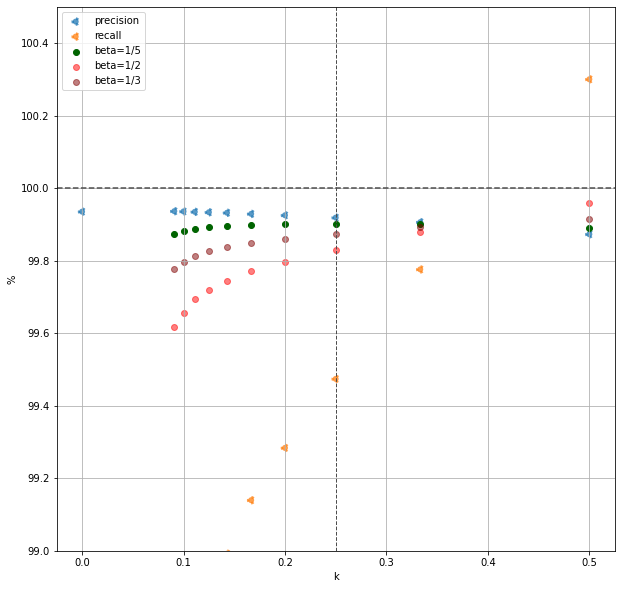

In [344]:
pr=np.array((data2))[:,0]
rec=np.array((data2))[:,1]

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(ks[np.argsort(ks)], pr[np.argsort(ks)], label='precision', alpha = 0.75,  linestyle = ':', lw=2.5)
ax.scatter(ks[np.argsort(ks)], rec[np.argsort(ks)], label='recall', alpha = 0.75,  linestyle = ':', lw=2.5)

ax.scatter(ks, (1+1/25)*pr*rec/(1/25*pr+rec), label='beta=1/5', c='darkgreen')
ax.scatter(ks, (1+1/4)*pr*rec/(1/4*pr+rec), label='beta=1/2',  alpha = 0.5, c='red')
ax.scatter(ks, (1+1/9)*pr*rec/(1/9*pr+rec), label='beta=1/3',  alpha = 0.5, c='maroon')

plt.axhline(100, c='0.3', linestyle = '--')
plt.axvline(best_k, c='0.3', linestyle = '--', lw=1)


ax.set_xlabel('k')
ax.set_ylabel('%')
plt.grid()
plt.legend()
plt.ylim(99,100.5)

# Лучшее k

In [98]:
massive=(1+1/25)*pr*rec/(1/25*pr+rec)

best_k=ks[np.where(massive == np.max(massive))[0][0]]
print(best_k, np.max(massive))

0.25 99.9022110450618


# MacthEX

In [140]:
def matchex_method(cat1, cat2, s, r, P, dens):
    
    coords1=SkyCoord(cat1['RA1'], cat1['DE1'], unit=[u.deg]*2)
    coords2=SkyCoord(cat2['RA2'], cat2['DE2'], unit=[u.deg]*2)
    
    a=SkyCoord.match_to_catalog_sky(coords1, coords2)
    
    xm_features={'ps_id': cat1.index,
             'sdss_id': cat2.iloc[a[0]].index,
             'sep, arcsec': a[1].to(u.arcsec).value}

    xm_result=pd.DataFrame(data=xm_features)

    xm_result=xm_result.astype({"ps_id": int,
                  "sdss_id": int,
                  'sep, arcsec': float})
    
    
    densities=dens
    
    cat2=xm_result.join(cat1, on='ps_id').join(cat2, on='sdss_id').join(densities, on='ps_id')
    
    rs=cat2['sep, arcsec']/(np.sqrt(cat2['e_RA1'].astype(float)**2
                                   +cat2['e_DE1'].astype(float)**2
                                   +cat2['e_RA2'].astype(float)**2
                                   +cat2['e_DE2'].astype(float)**2))

    probs=np.exp(-cat2['loc. density']*np.pi*cat2['sep, arcsec']**2)

    cat2['r']=rs
    cat2['P']=probs
    
    
    return cat2.loc[(cat2['sep, arcsec']<s)&(cat2['r']<r)&(cat2['P']>P)]

In [148]:
cat=matchex_method(ps, sdss12_1, 5, 10, 0.95, densities)

In [144]:
def get_precision_matchex(cat):
    
    return np.sum(cat['P'])/len(cat)*100

In [149]:
get_precision_matchex(cat)

99.91730477194395

In [153]:
get_recall(cat, all_neighbours)

90.31913857566532

In [224]:
p_s=np.linspace(0.7, 0.99, 10)
r_s=np.linspace(30, 100, 10)

In [225]:
treD=[]

for p in p_s:
    for r in r_s:
        
        mex=matchex_method(ps, sdss12_1, 5, r, p, densities)
        
        treD.append([r, p, get_precision_matchex(mex), get_recall(mex, all_neighbours)])

In [342]:
res3=pd.DataFrame(np.array((treD)), columns=['r', 'p', 'precision', 'recall'])
res3['F0.2']=get_beta(res3, 0.2)
res3.nlargest(45, 'F0.2')[35:]
# res3[40:60]

,r,p,precision,recall,F0.2
63,53.333333,0.893333,99.788398,100.600568,99.819393
62,45.555556,0.893333,99.792826,100.322297,99.813087
70,30.000000,0.925556,99.856766,98.668058,99.810517
61,37.777778,0.893333,99.801681,99.808459,99.801942
60,30.000000,0.893333,99.815398,98.903276,99.780006
56,76.666667,0.861111,99.710549,101.280998,99.770050
57,84.444444,0.861111,99.708143,101.335264,99.769758
58,92.222222,0.861111,99.706231,101.378954,99.769545
55,68.888889,0.861111,99.712816,101.196100,99.769060
59,100.000000,0.861111,99.704363,101.402892,99.768638


In [227]:
D1=np.array((treD))
n=int(np.sqrt(np.shape(D1)[0]))

In [303]:
from matplotlib import cm

D1=np.array((treD))
n=int(np.sqrt(np.shape(D1)[0]))
np.shape(D1)
X=D1[:,0].reshape(n, n)
Y=D1[:,1].reshape(n, n)
beta=1/4.5
Z=(((1+beta**2)*D1[:,2]*D1[:,3])/(beta**2*D1[:,2]+D1[:,3])).reshape(n, n)

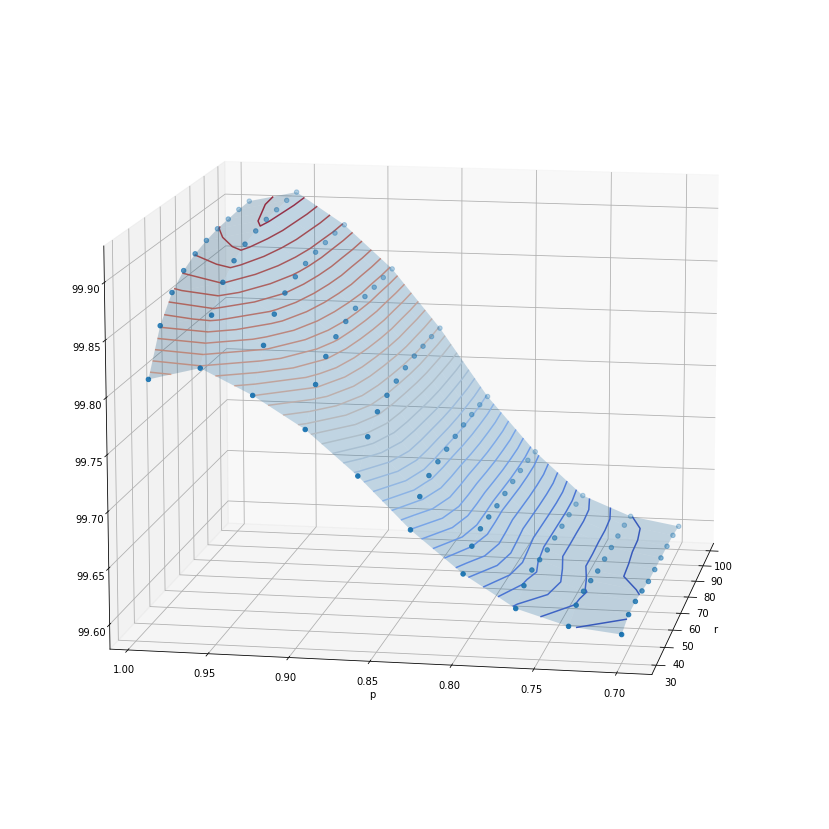

In [324]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap=cm.coolwarm)
ax.scatter3D(X, Y, Z, 'k')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.25)


# ax.set_zlim(-1, 5)
# ax.set_xlim(0.45, 1.05)
# ax.set_ylim(0, 100)

ax.set_xlabel('r')
ax.set_ylabel('p')
plt.savefig('figure10')
ax.view_init(12, 190)


In [326]:
treD

[[30.0, 0.7, 99.6061164187105, 99.55295787738652],
 [37.77777777777778, 0.7, 99.56289939724668, 100.55798247826452],
 [45.55555555555556, 0.7, 99.53515931641722, 101.13544373773703],
 [53.33333333333333, 0.7, 99.51736157201145, 101.46172962494629],
 [61.111111111111114, 0.7, 99.5040662731045, 101.67869718627003],
 [68.88888888888889, 0.7, 99.4975840253445, 101.80691304403399],
 [76.66666666666666, 0.7, 99.49276632881026, 101.89977588882142],
 [84.44444444444444, 0.7, 99.48996676936102, 101.95563659486047],
 [92.22222222222223, 0.7, 99.487121146139, 102.00257502846961],
 [100.0, 0.7, 99.48334047133355, 102.03270452984043],
 [30.0, 0.7322222222222222, 99.61200383728865, 99.54224275972261],
 [37.77777777777778,
  0.7322222222222222,
  99.57021450759581,
  100.54444810430553],
 [45.55555555555556,
  0.7322222222222222,
  99.54335083956998,
  101.12021182874096],
 [53.33333333333333, 0.7322222222222222, 99.5258216665698, 101.44595117806182],
 [61.111111111111114,
  0.7322222222222222,
  99.

In [306]:
np.max(Z)

99.90889910744019